# Import all Libs

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
import os
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

# Count no of files

In [5]:
# folder path
dir_path = r'bone-shadow-supression/BB/augmented/augmented/source'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 4080


# Data preprocessing

In [6]:
no_of_images = 4080
img_size = (224,224)
imgs_source = []
imgs_target = []

dir_source = "bone-shadow-supression/BB/augmented/augmented/source"
dir_target = "bone-shadow-supression/BB/augmented/augmented/target"

i = 0
for _, _, filenames in os.walk('bone-shadow-supression/BB/augmented/augmented/source/'):
    for filename in filenames:
        print(i)
        i = i+1
        if(i > no_of_images):
            break
        img_source = cv2.imread(os.path.join(dir_source,filename),cv2.IMREAD_GRAYSCALE)
        img_target = cv2.imread(os.path.join(dir_target, filename),cv2.IMREAD_GRAYSCALE)
        # resizing images
        img_source = cv2.resize(img_source,img_size)
        img_target = cv2.resize(img_target,img_size)
        # normalizing images
        img_source = np.array(img_source)/255
        img_target = np.array(img_target)/255

        imgs_source.append(img_source)
        imgs_target.append(img_target)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
print(len(imgs_source))
print(len(imgs_target))

4080
4080


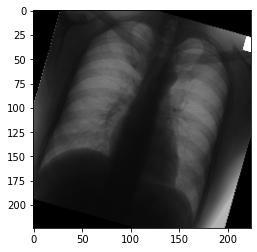

In [8]:
import matplotlib.pyplot as plt
plt.imshow(imgs_source[1],cmap='gray')
plt.gray()

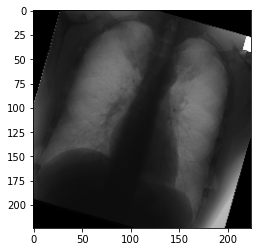

In [9]:
import matplotlib.pyplot as plt
plt.imshow(imgs_target[1])
plt.gray()

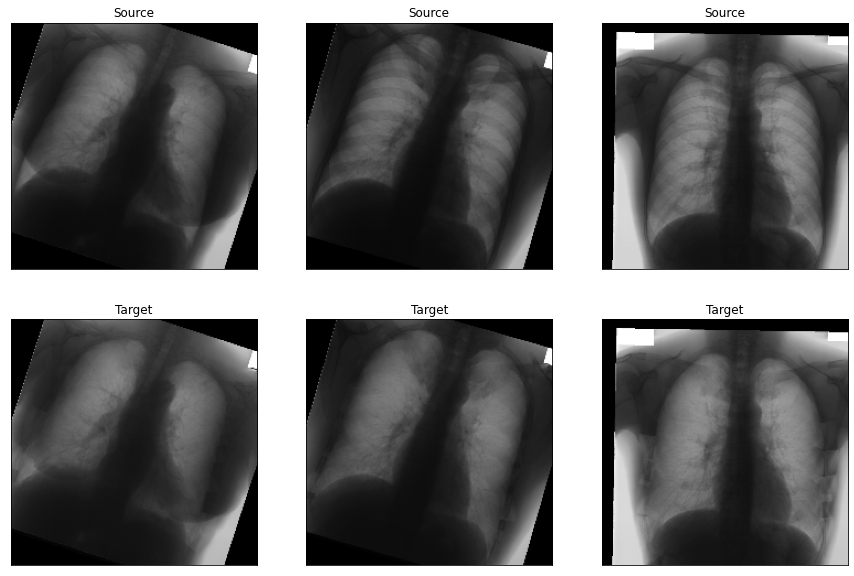

In [10]:
plt.figure(figsize=(15,10))

for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(imgs_source[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source')

    ax = plt.subplot(2, 3, i+4)
    plt.imshow(imgs_target[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

## Slit to train-test

In [11]:
img_rows = 224
img_cols = 224
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

source = np.array(imgs_source).reshape(-1, img_rows, img_cols, img_channels)
target = np.array(imgs_target).reshape(-1, img_rows, img_cols, img_channels)

source_train, source_test, target_train, target_test = train_test_split(source, target,
                                                                        test_size=0.20,
                                                                        random_state=1)

In [12]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

(3264, 224, 224, 1) (816, 224, 224, 1) (3264, 224, 224, 1) (816, 224, 224, 1)


# Create AutoEncoder Model

In [14]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [15]:
img_shape

(224, 224, 1)

In [17]:
input_img = Input(shape = img_shape)
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop() ,metrics=["mae","mse"])

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0     

## Model Fit

In [19]:
n_epoch = 50
n_batch = 32
autoencoder_train = autoencoder.fit(source_train, target_train,
                                    epochs = n_epoch,
                                    batch_size = n_batch,
                                    verbose = 1,
                                    validation_data = (source_test, target_test))

Epoch 1/50
102/102 [==============================] - 18s 122ms/step - loss: 0.0214 - mae: 0.0938 - mse: 0.0214 - val_loss: 0.0304 - val_mae: 0.1347 - val_mse: 0.0304
Epoch 2/50
102/102 [==============================] - 10s 99ms/step - loss: 0.0049 - mae: 0.0443 - mse: 0.0049 - val_loss: 0.0353 - val_mae: 0.1557 - val_mse: 0.0353
Epoch 3/50
102/102 [==============================] - 10s 99ms/step - loss: 0.0031 - mae: 0.0349 - mse: 0.0031 - val_loss: 0.0232 - val_mae: 0.1164 - val_mse: 0.0232
Epoch 4/50
102/102 [==============================] - 10s 99ms/step - loss: 0.0023 - mae: 0.0305 - mse: 0.0023 - val_loss: 0.0149 - val_mae: 0.0996 - val_mse: 0.0149
Epoch 5/50
102/102 [==============================] - 11s 108ms/step - loss: 0.0018 - mae: 0.0274 - mse: 0.0018 - val_loss: 0.0072 - val_mae: 0.0718 - val_mse: 0.0072
Epoch 6/50
102/102 [==============================] - 12s 113ms/step - loss: 0.0020 - mae: 0.0262 - mse: 0.0020 - val_loss: 0.0034 - val_mae: 0.0465 - val_mse: 0.0034
E

In [20]:
interval_epochs = [0, 49]
for e in interval_epochs:
    print("epoch = {}\tLoss = {:.5f}\tValidation_Loss = {:.5f}".format(e+1,autoencoder_train.history['loss'][e],autoencoder_train.history['val_loss'][e]))

epoch = 1	Loss = 0.02142	Validation_Loss = 0.03039
epoch = 50	Loss = 0.00089	Validation_Loss = 0.00081


# Results

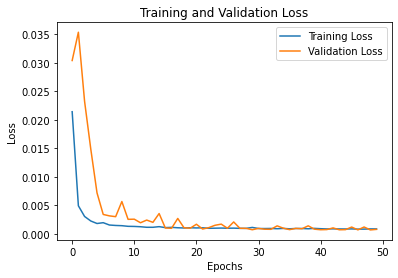

In [21]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['loss'], label = 'Training Loss')
plt.plot(n, autoencoder_train.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

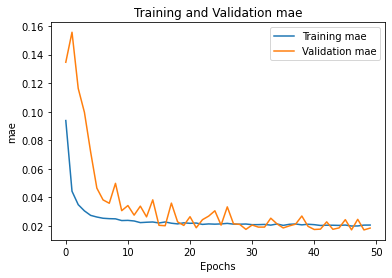

In [65]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['mae'], label = 'Training mae')
plt.plot(n, autoencoder_train.history['val_mae'], label = 'Validation mae')
plt.title('Training and Validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()

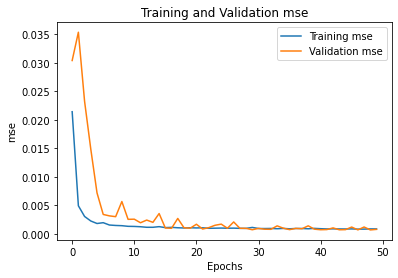

In [66]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['mse'], label = 'Training mse')
plt.plot(n, autoencoder_train.history['val_mse'], label = 'Validation mse')
plt.title('Training and Validation mse')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()

# See the prediction results

In [23]:
source_test.shape

(816, 224, 224, 1)

In [24]:
pred = autoencoder.predict(source_test)

26/26 [==============================] - 1s 35ms/step


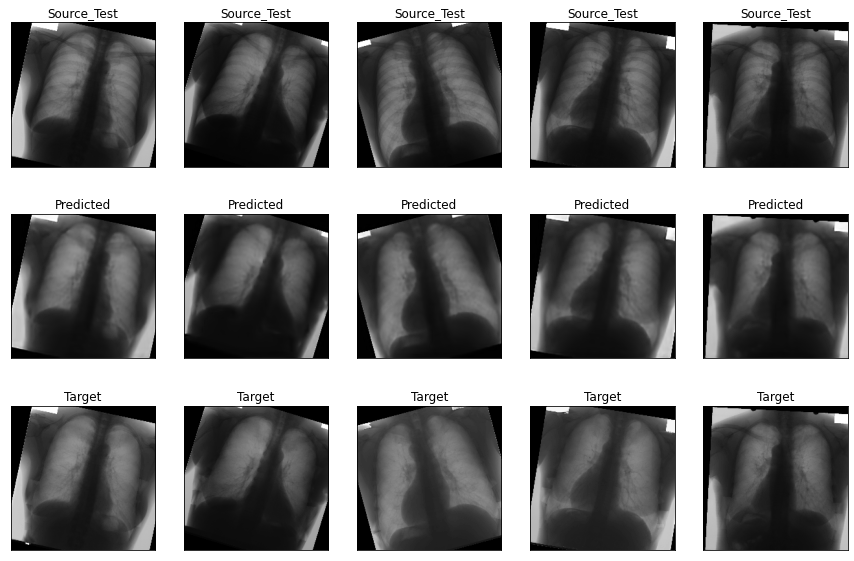

In [25]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')

    ax = plt.subplot(3, 5, i+11)
    plt.imshow(target_test[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

In [26]:
target_test.shape

(816, 224, 224, 1)

# See the prediction results on NIH dataset

In [59]:
test1 = []
test = cv2.imread('C:/Users/Rugved Chavan/Desktop/GAIP Project/cleaned_data/Pneumonia/00000591_004.png',cv2.IMREAD_GRAYSCALE)
# resizing images
test = cv2.resize(test,(224,224))
# normalizing images
test = np.array(test)/255
test1.append(test)

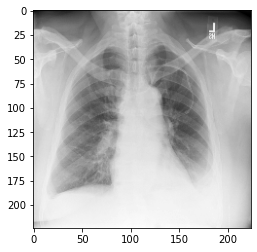

In [60]:
plt.imshow(test1[0])

In [61]:
img_rows = 224
img_cols = 224
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

test2 = np.array(test1).reshape(-1, img_rows, img_cols, img_channels)

In [62]:
test2.shape

(1, 224, 224, 1)

In [63]:
pred1 = autoencoder.predict(test2)

1/1 [==============================] - 0s 13ms/step


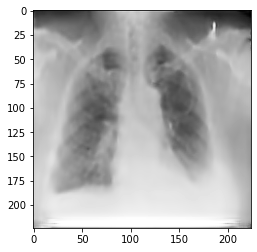

In [64]:
plt.imshow(pred1[0],  cmap='gray')
plt.imsave('results5.png',np.squeeze(pred1[0]),  cmap='gray')